In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('yelp_polarity_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0.incompleteEAUSBZ/yelp_polarity_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0.incompleteEAUSBZ/yelp_polarity_reviews-test.tfrecord
Dataset yelp_polarity_reviews downloaded and prepared to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"The Groovy P. and I ventured to his old stomping grounds for lunch today.  The '5 and Diner' on 16th St and Colter left me with little to ask for.  Before coming here I had a preconceived notion that 5 & Diners were dirty and nasty. Not the case at all.\\n\\nWe walk in and let the waitress know we want to sit outside (since it's so nice and they had misters).  We get two different servers bringing us stuff (talk about service) and I ask the one waitress for recommendations.  I didn't listen to her, of course, and ordered the Southwestern Burger w/ coleslaw and started with a nice stack of rings.\\n\\nThe Onion Rings were perfectly cooked.  They looked like they were prepackaged, but they were very crispy and I could actually bite through the onion without pulling the entire thing out (don't you hate that?!!!)\\n\\nThe Southwestern Burger was order Medium Rare and was cooked accordingly.  Soft, juicy, and pink with a nice crispy browned outer layer that can only be achieved on 

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"WinCo is fairly close to me and my dad was really excited they were coming to the East Valley, and especially near where we live.  However, the prices aren't all that inexpensive.  However, they have a reasonably good bulk section, which is why we come here and their prices for some of their deli stuff is better than Safeway, which is usually where we go for things like chicken strips, fried chicken, wedges.  WinCo's stuff tastes good and it's much better pricing for that.\\n\\nWe buy protein powder and it's about $3-4/lb less than Sprouts for their whey protein.  We love that they carry spices in bulk, and you can get what you want, which saves us money, too.\\n\\nEveryone that we've dealt with at WinCo has been super friendly and helpful.  The store is spacious and clean.  \\n\\nThe only downside is that some of their prices are competitive, but since they have no weekly ads, it's hard for them to compete with Frys and the stores that sometimes have killer weekly specials.

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 1, 12,  1, ...,  0,  0,  0],
       [53, 99, 53, ...,  0,  0,  0],
       [16, 12,  2, ...,  0,  0,  0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"WinCo is fairly close to me and my dad was really excited they were coming to the East Valley, and especially near where we live.  However, the prices aren't all that inexpensive.  However, they have a reasonably good bulk section, which is why we come here and their prices for some of their deli stuff is better than Safeway, which is usually where we go for things like chicken strips, fried chicken, wedges.  WinCo's stuff tastes good and it's much better pricing for that.\\n\\nWe buy protein powder and it's about $3-4/lb less than Sprouts for their whey protein.  We love that they carry spices in bulk, and you can get what you want, which saves us money, too.\\n\\nEveryone that we've dealt with at WinCo has been super friendly and helpful.  The store is spacious and clean.  \\n\\nThe only downside is that some of their prices are competitive, but since they have no weekly ads, it's hard for them to compete with Frys and the stores that sometimes have killer weekly special

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
 history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
4375/4375 [==============================] - 717s 159ms/step - loss: 0.2658 - accuracy: 0.8788 - val_loss: 0.2170 - val_accuracy: 0.9055
Epoch 2/10
4375/4375 [==============================] - 685s 156ms/step - loss: 0.2271 - accuracy: 0.9026 - val_loss: 0.2120 - val_accuracy: 0.9107
Epoch 3/10
4375/4375 [==============================] - 690s 158ms/step - loss: 0.2202 - accuracy: 0.9056 - val_loss: 0.2042 - val_accuracy: 0.9042
Epoch 4/10
4375/4375 [==============================] - 689s 157ms/step - loss: 0.2088 - accuracy: 0.9106 - val_loss: 0.1862 - val_accuracy: 0.9182
Epoch 5/10
4375/4375 [==============================] - 687s 157ms/step - loss: 0.1928 - accuracy: 0.9180 - val_loss: 0.1750 - val_accuracy: 0.9258
Epoch 6/10
4375/4375 [==============================] - 688s 157ms/step - loss: 0.1798 - accuracy: 0.9245 - val_loss: 0.1684 - val_accuracy: 0.9289
Epoch 7/10
4375/4375 [==============================] - 705s 161ms/step - loss: 0.1704 - accuracy: 0.9285 - val_

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

297/297 [==============================] - 19s 64ms/step - loss: 0.1540 - accuracy: 0.9376
Test Loss: 0.15396225452423096
Test Accuracy: 0.9375526309013367


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

297/297 [==============================] - 19s 64ms/step - loss: 0.1540 - accuracy: 0.9376
Test Loss: 0.15396225452423096
Test Accuracy: 0.9375526309013367


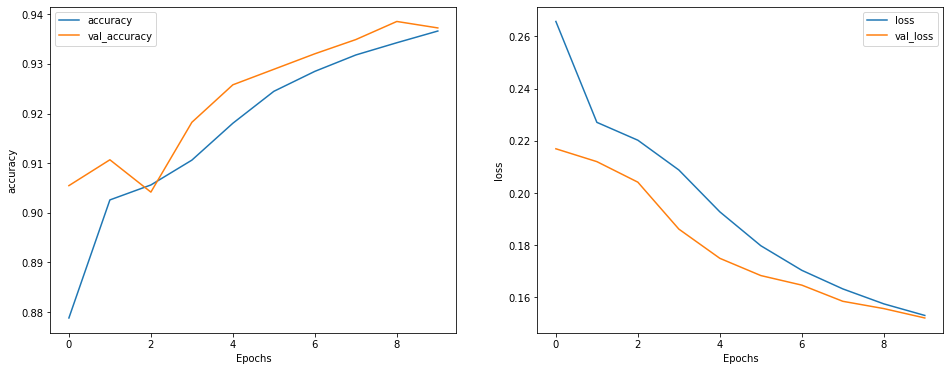

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')